In [ ]:
import yfinance as yf
import pandas as pd
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress UserWarnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings


tickers = [
    'SPY',   # S&P 500 ETF
    'XLB',   # Materials
    'XLE',   # Energy
    'XLF',   # Financials
    'XLI',   # Industrials
    'XLK',   # Technology
    'XLP',   # Consumer Staples
    'XLU',   # Utilities
    'XLV',   # Health Care
    'XLY',   # Consumer Discretionary
    'XLRE',  # Real Estate
    'XLC'    # Communication Services
]
def get_X_y(tickers_ls):
    data = yf.download(tickers_ls, start='2010-01-01', end='2024-11-16')['Adj Close']
    data.dropna(inplace=True)
    returns_df = data.pct_change().dropna()
    X = returns_df[['XLB', 'XLE','XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY', 'XLRE', 'XLC' ]].shift(1).dropna()
    y = returns_df["SPY"][1:]
    return X,y



In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm

def rolling_predictions(X, y, window_size = 1000):
    predictions = []  
    dates = y.index[window_size:]  

    # Iterate over the data using a rolling window
    for end_idx in tqdm(range(window_size, len(y)), desc="Iterating through len(y) - 1000:"):
        # Define the training window
        start_idx = end_idx - window_size
        y_train = y.iloc[start_idx:end_idx]
        X_train = X.iloc[start_idx:end_idx]

        model = ARIMA(y_train, exog=X_train, order=(5, 1, 0))
        model_fit = model.fit()
        # arima_model = pm.arima.auto_arima(y=y_train, X=X_train)   
        pred_features = X.iloc[end_idx]

        # pred_features = pd.DataFrame(pred_features)
        prediction = model_fit.predict(X=pred_features)

        predictions.append(prediction.iloc[0])

    results = pd.DataFrame({'Date': dates, 'Prediction': predictions})
    results.set_index('Date', inplace=True)
    results.to_csv(f'rolling_window_predictions_{window_size}.csv')

In [19]:
X, y = get_X_y(tickers)
# print(y)
ls = [1000]
for roll_wind in ls:
    rolling_predictions(X,y, window_size=roll_wind)


[*********************100%***********************]  12 of 12 completed
Iterating through len(y) - 1000::   0%|          | 0/606 [00:00<?, ?it/s]f:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

[*********************100%***********************]  12 of 12 completed


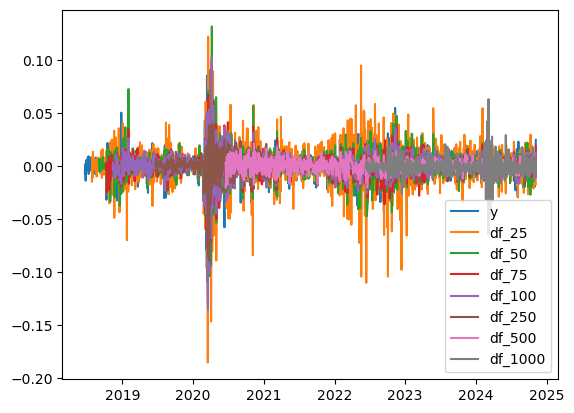

Metrics for window size 25: {'mae': 0.015429407605014843, 'mse': 0.0005536940957627041, 'rmse': 0.023530705381749693, 'mape': inf, 'directional_accuracy': 50.60088551549652, 'r_squared': -2.5238242450966983}
Metrics for window size 50: {'mae': 0.012082972029844865, 'mse': 0.000331598139688027, 'rmse': 0.01820983634435046, 'mape': inf, 'directional_accuracy': 51.60668380462725, 'r_squared': -1.0815448325954242}
Metrics for window size 75: {'mae': 0.011067509903811881, 'mse': 0.0002762320600101403, 'rmse': 0.016620230443954147, 'mape': inf, 'directional_accuracy': 50.228608752449375, 'r_squared': -0.7085123705596399}
Metrics for window size 100: {'mae': 0.01050500652914717, 'mse': 0.00025714904733067034, 'rmse': 0.016035867526600186, 'mape': inf, 'directional_accuracy': 51.66002656042497, 'r_squared': -0.5980057266238428}
Metrics for window size 250: {'mae': 0.009871449840210563, 'mse': 0.0002222809284167595, 'rmse': 0.014909088785595164, 'mape': inf, 'directional_accuracy': 52.286135693

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def read_csv_ian(filename):
    df_output = pd.read_csv(filename)
    df_output["Date"] = pd.to_datetime(df_output["Date"])
    df_output.set_index("Date", inplace=True)
    return df_output

# Function to calculate performance metrics
def get_perf_metrics(actual_values, predicted_values):
    mae = mean_absolute_error(actual_values, predicted_values)
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    sign_count = sum(np.sign(actual_values.iloc[i]) == np.sign(predicted_values.iloc[i]) for i in range(len(actual_values)))
    directional_accuracy = (sign_count / len(actual_values)) * 100
    r_squared = r2_score(actual_values, predicted_values)
    return {
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "mape": mape,
        "directional_accuracy": directional_accuracy,
        "r_squared": r_squared
    }

X, y = get_X_y(tickers)
window_sizes = [25, 50, 75, 100, 250, 500, 1000]
metrics_dict = {}

plt.plot(y, label='y')

for window_size in window_sizes:
    
    df = read_csv_ian(f"rolling_window_predictions_{window_size}.csv")
    plt.plot(df, label=f'df_{window_size}')
    metrics = get_perf_metrics(y[window_size:], df["Prediction"])
    metrics_dict[window_size] = metrics

plt.legend()
plt.show()

for window_size, metrics in metrics_dict.items():
    print(f"Metrics for window size {window_size}: {metrics}")
